 <font size="6"><p style="text-align:center"><b> Определение возраста покупателей </b></p></font>

<div class="alert alert-dan
            ger">
<font size="4"><b>План:</b></font>
    <br /> 
    <font size="3", color = "black">
<br />

- В нашем распоряжении файл с фотографиями потенциальных клиентов магазина Хлеб-соль.    
        
- Создадим и оценим модель, предсказывающую возраст клиента. Это поможет контролировать работу кассира и не допустить продажу алкоголя несовершеннолетним. А также предлагать товары, имеющие спрос у данной возрастной категории, что потенциально может повысить лояльность клиента и выручку.

<font size="5"><p style="text-align:center"><b> ***Шаг 1. Исследовательский анализ данных*** </b></p></font>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from tensorflow.keras.layers import Conv2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

In [2]:
age = pd.read_csv('/datasets/faces/labels.csv')

datagen = ImageDataGenerator(rescale=1/255) 

datagen_flow = datagen.flow_from_dataframe(
    dataframe=age,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224), 
    batch_size=32,
    class_mode='raw',
    seed=12345) 

Found 7591 validated image filenames.


In [3]:
age.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
age.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


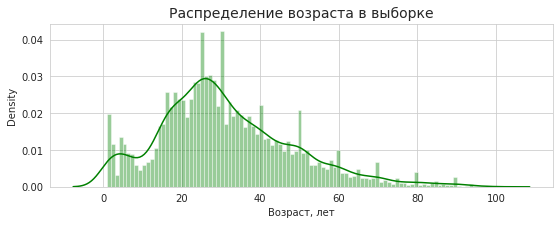

In [5]:
plt.figure(figsize=(9,3))
sns.distplot(age['real_age'], color='green', bins=100)
plt.title('Распределение возраста в выборке', size=14)
plt.xlabel('Возраст, лет');

In [6]:
age['real_age'].min()

1

In [7]:
age['real_age'].max()

100

In [8]:
age['real_age'].value_counts().head(10)

30    317
25    315
27    229
26    226
28    217
23    213
24    211
18    193
16    193
19    180
Name: real_age, dtype: int64

7591 изображение в выборке, пропусков нет. 

Представлены фото людей от года до ста лет. Больше всего фотографий людей в возрасте от 16 до 30 лет.

Среди фото есть чёрно-белые.

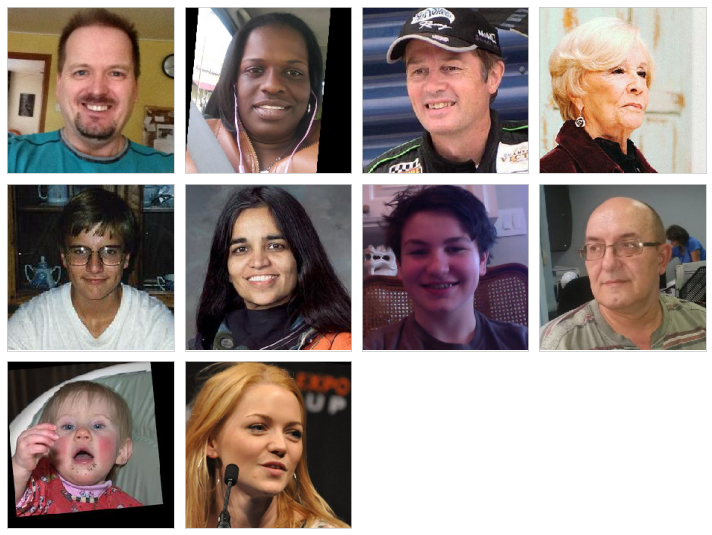

In [9]:
features, target = next(datagen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(10):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Мы исследуем выборку в том числе для того, чтобы знать, нужна ли будет заморозка слоёв при написании ResNet или не нужна. В данном случае применять её не будем, датасет не такой уж маленький.

<font size="5"><p style="text-align:center"><b> ***Шаг 2. Обучение модели*** </b></p></font>

```python

age = pd.read_csv('/datasets/faces/labels.csv')

def load_train(path):
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale = 1/255, horizontal_flip=True)
    train_datagen_flow = train_datagen.flow_from_dataframe(
    dataframe=age,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset='training',
    seed=12345)
    return train_datagen_flow

def load_test(path):
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale = 1/255)
    test_datagen_flow = test_datagen.flow_from_dataframe(
    dataframe=age,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset='validation',
    seed=12345)
    return test_datagen_flow

def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mse',
              optimizer=optimizer, metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=5,
               steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
          validation_data=test_data,
          batch_size=batch_size,
          steps_per_epoch=steps_per_epoch,
          validation_steps=validation_steps,
          verbose=2, epochs=epochs, shuffle=True)
    return model
```

```
Epoch 1/5

178/178 - 47s - loss: 238.9365 - mae: 11.0997 - val_loss: 925.5863 - val_mae: 25.6140

Epoch 2/5

178/178 - 42s - loss: 76.1256 - mae: 6.5714 - val_loss: 861.1775 - val_mae: 24.4411

Epoch 3/5

178/178 - 49s - loss: 48.4759 - mae: 5.3142 - val_loss: 252.2046 - val_mae: 11.7348

Epoch 4/5

178/178 - 52s - loss: 34.8438 - mae: 4.4848 - val_loss: 111.1662 - val_mae: 8.0143

Epoch 5/5

178/178 - 54s - loss: 26.2754 - mae: 3.9154 - val_loss: 68.7860 - val_mae: 6.2582


60/60 - 11s - loss: 68.7860 - mae: 6.2582

Test MAE: 6.2582

```

 <font size="5"><p style="text-align:center"><b> ***Шаг 3. Анализ обученной модели*** </b></p></font>

Перед нами стояла задача создать модель для определния возраста покупателей магазина Хлеб-Соль для контроля продажи алкоголя несовершеннолетним и возможности повысить выручку при предложении покупателю определённой возрастной категории нужных ему товаров.

Нами был исследован датасет с 7591 изображениями - фото потенциальных покупателей магазина Хлеб-Соль. 

В исследованном датасете большинство изображённых людей в возрасте 20-30 лет. Это нужно учитывать, так как среди покупателей продуктового магазина обычно больше людей среднего возраста и достаточно много пенсионеров. 

Мы создали модель ResNet50, не используя заморозку, так как датасет достаточен по объёму и риск переобучения не так высок.

Мы добились МАЕ 6.3 на тестовой выборке. Это значит, что в среднем модель может ошибиться на 6 лет в старшую или младшую сторону. Это не удовлетворяет одной из наших целей - контроль продажи алкоголя, так как в таком случае 13-летний подросток может быть ошибочно распознан моделью как совершеннолетний человек. Но второй цели - предложение необходимых товаров - эта модель может способствовать.